In [ ]:
import pandas as pd
import numpy as np
import string

In [ ]:
train = pd.read_csv('./spooky_author_identification/train.csv')
test = pd.read_csv('./spooky_author_identification/test.csv')
sample = pd.read_csv('./spooky_author_identification/sample_submission.csv')

In [ ]:
train.head(5)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [ ]:
test.head(5)

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [ ]:
sample.head(5)

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [ ]:
print("Train: rows:{} cols:{}".format(train.shape[0], train.shape[1]))
print("Test: rows:{} cols:{}".format(test.shape[0], test.shape[1]))
print("Sample: rows:{} cols:{}".format(sample.shape[0], sample.shape[1]))

Train: rows:19579 cols:3
Test: rows:8392 cols:2
Sample: rows:8392 cols:4


**Check Missing Value**

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [ ]:
missing_data(train)

,Total,Percent
id,0,0.0
text,0,0.0
author,0,0.0


In [ ]:
missing_data(test)

,Total,Percent
id,0,0.0
text,0,0.0


In [ ]:
empty_text_train = train[train['text'].str.strip() == ''].shape[0]
empty_text_test = test[test['text'].str.strip() == ''].shape[0]
print("Empty Text Train: {}".format(empty_text_train))
print("Empty Text Test: {}".format(empty_text_test))

Empty Text Train: 0
Empty Text Test: 0


**Duplicate and Leakage Check**

In [ ]:
duplicate_count = train.duplicated().sum()
print("Duplicate Count: {}".format(duplicate_count))

Duplicate Count: 0


In [ ]:
leakage = train[train['text'].isin(test['text'])]
leakage

,id,text,author


**Exploratory Data Analysis (EDA)**

#### Target Distribution

/tmp/ipython-input-225751682.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='author', data=train, palette='viridis')


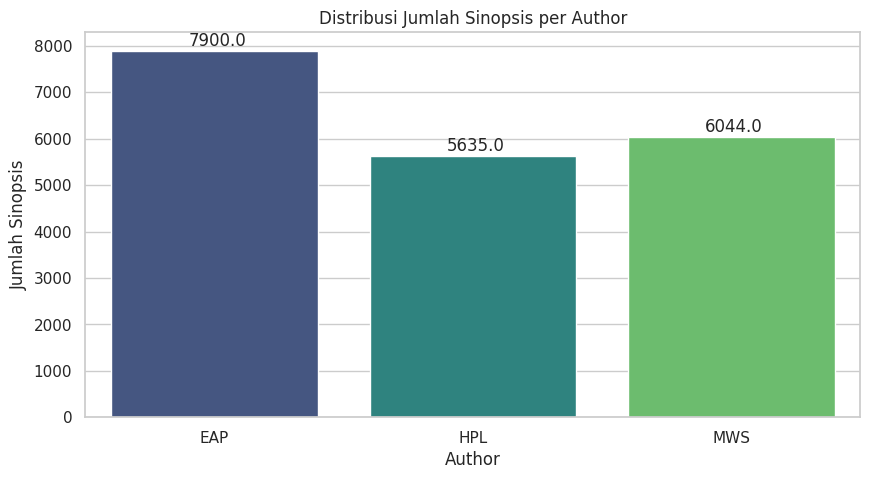

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
ax = sns.countplot(x='author', data=train, palette='viridis')

plt.title('Distribusi Jumlah Sinopsis per Author')
plt.xlabel('Author')
plt.ylabel('Jumlah Sinopsis')

for p in ax.patches:
  ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height()+100))

plt.show()

#### Feature Extraction

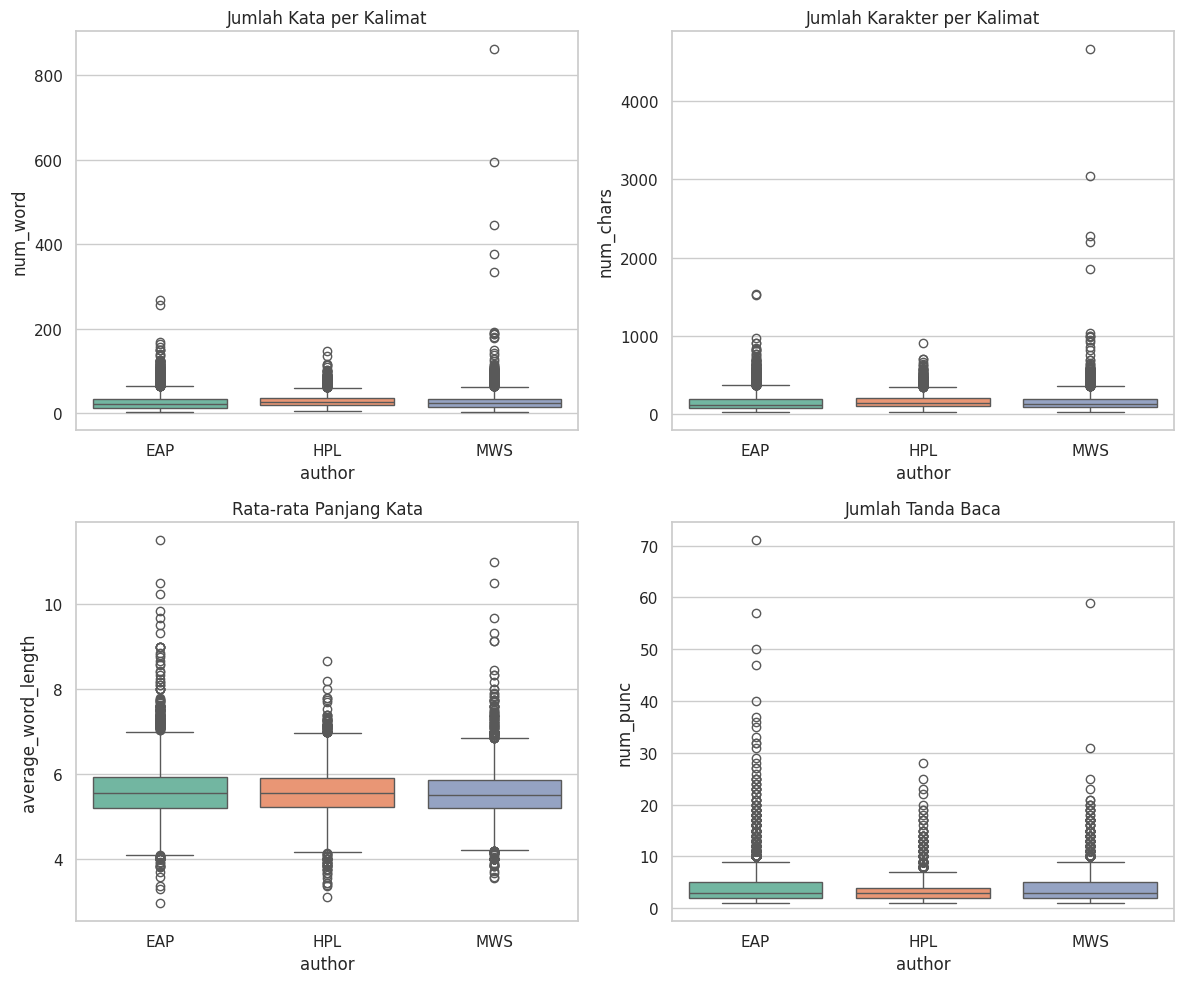

In [ ]:
from matplotlib.figure import figaspect
# jumlah kata per kalimat
train['num_word'] = train['text'].apply(lambda x:len(str(x).split()))

#jumlah karakter per kalimat
train['num_chars'] = train['text'].apply(lambda x:len(str(x)))

train['average_word_length'] = train['num_chars']/train['num_word']

#jumlah tanda baca
train['num_punc'] = train['text'].apply(lambda x:len([c for c in str(x) if c in string.punctuation]))

f, axes = plt.subplots(2, 2, figsize=(12,10))

sns.boxplot(x='author', y='num_word', hue = 'author', data=train, ax=axes[0,0], palette='Set2')
axes[0,0].set_title('Jumlah Kata per Kalimat')

sns.boxplot(x='author', y='num_chars', hue = 'author', data=train, ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Jumlah Karakter per Kalimat')

sns.boxplot(x='author', y='average_word_length', hue = 'author', data=train, ax=axes[1,0], palette='Set2')
axes[1,0].set_title('Rata-rata Panjang Kata')

sns.boxplot(x='author', y='num_punc', hue = 'author', data=train, ax=axes[1,1], palette='Set2')
axes[1,1].set_title('Jumlah Tanda Baca')

plt.tight_layout()
plt.show()

##### Word Cloud

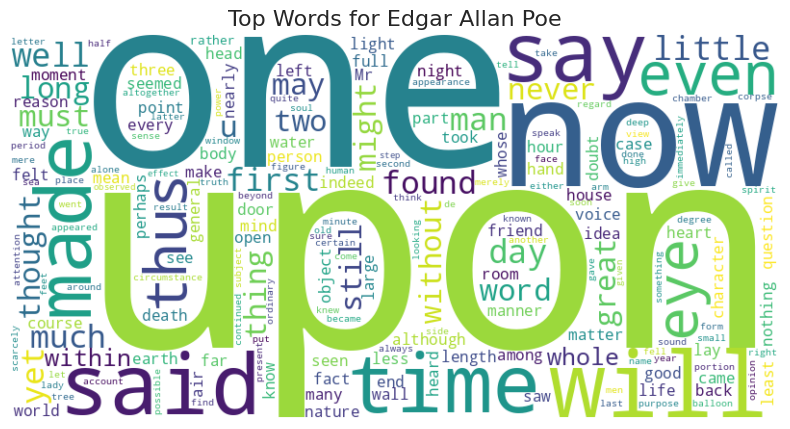

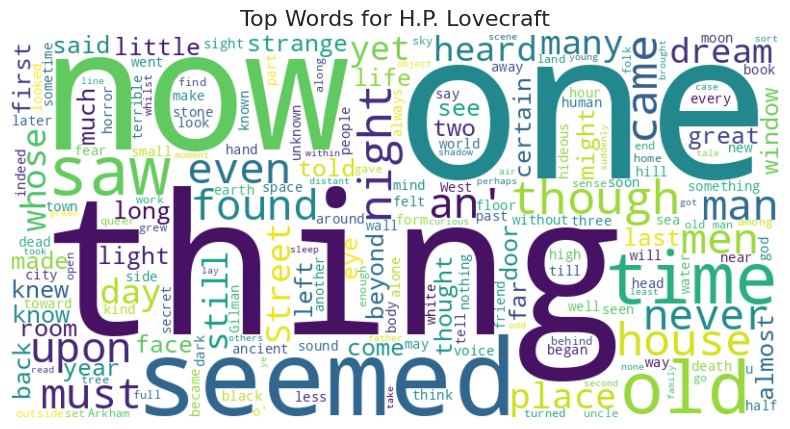

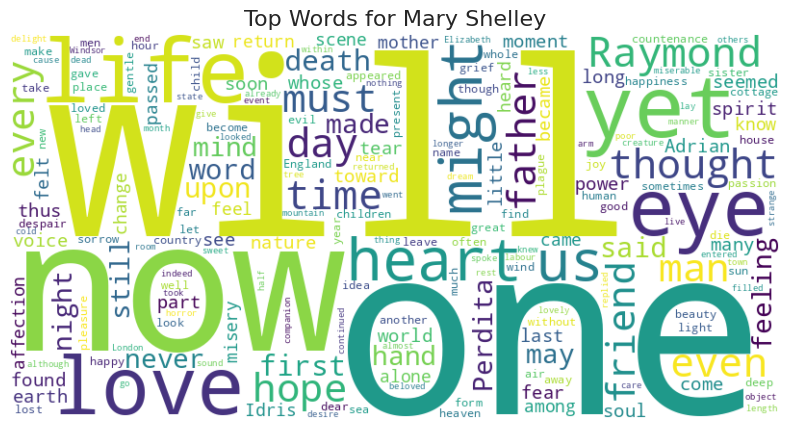

In [ ]:
from wordcloud import WordCloud

def plot_wordcloud(author_code, title):
  text = " ".join(train[train['author'] == author_code]['text'].values)
  wc = WordCloud(width=800, height=400, background_color='white').generate(text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title(title, fontsize=16)
  plt.show()

plot_wordcloud('EAP', 'Top Words for Edgar Allan Poe')
plot_wordcloud('HPL', 'Top Words for H.P. Lovecraft')
plot_wordcloud('MWS', 'Top Words for Mary Shelley')

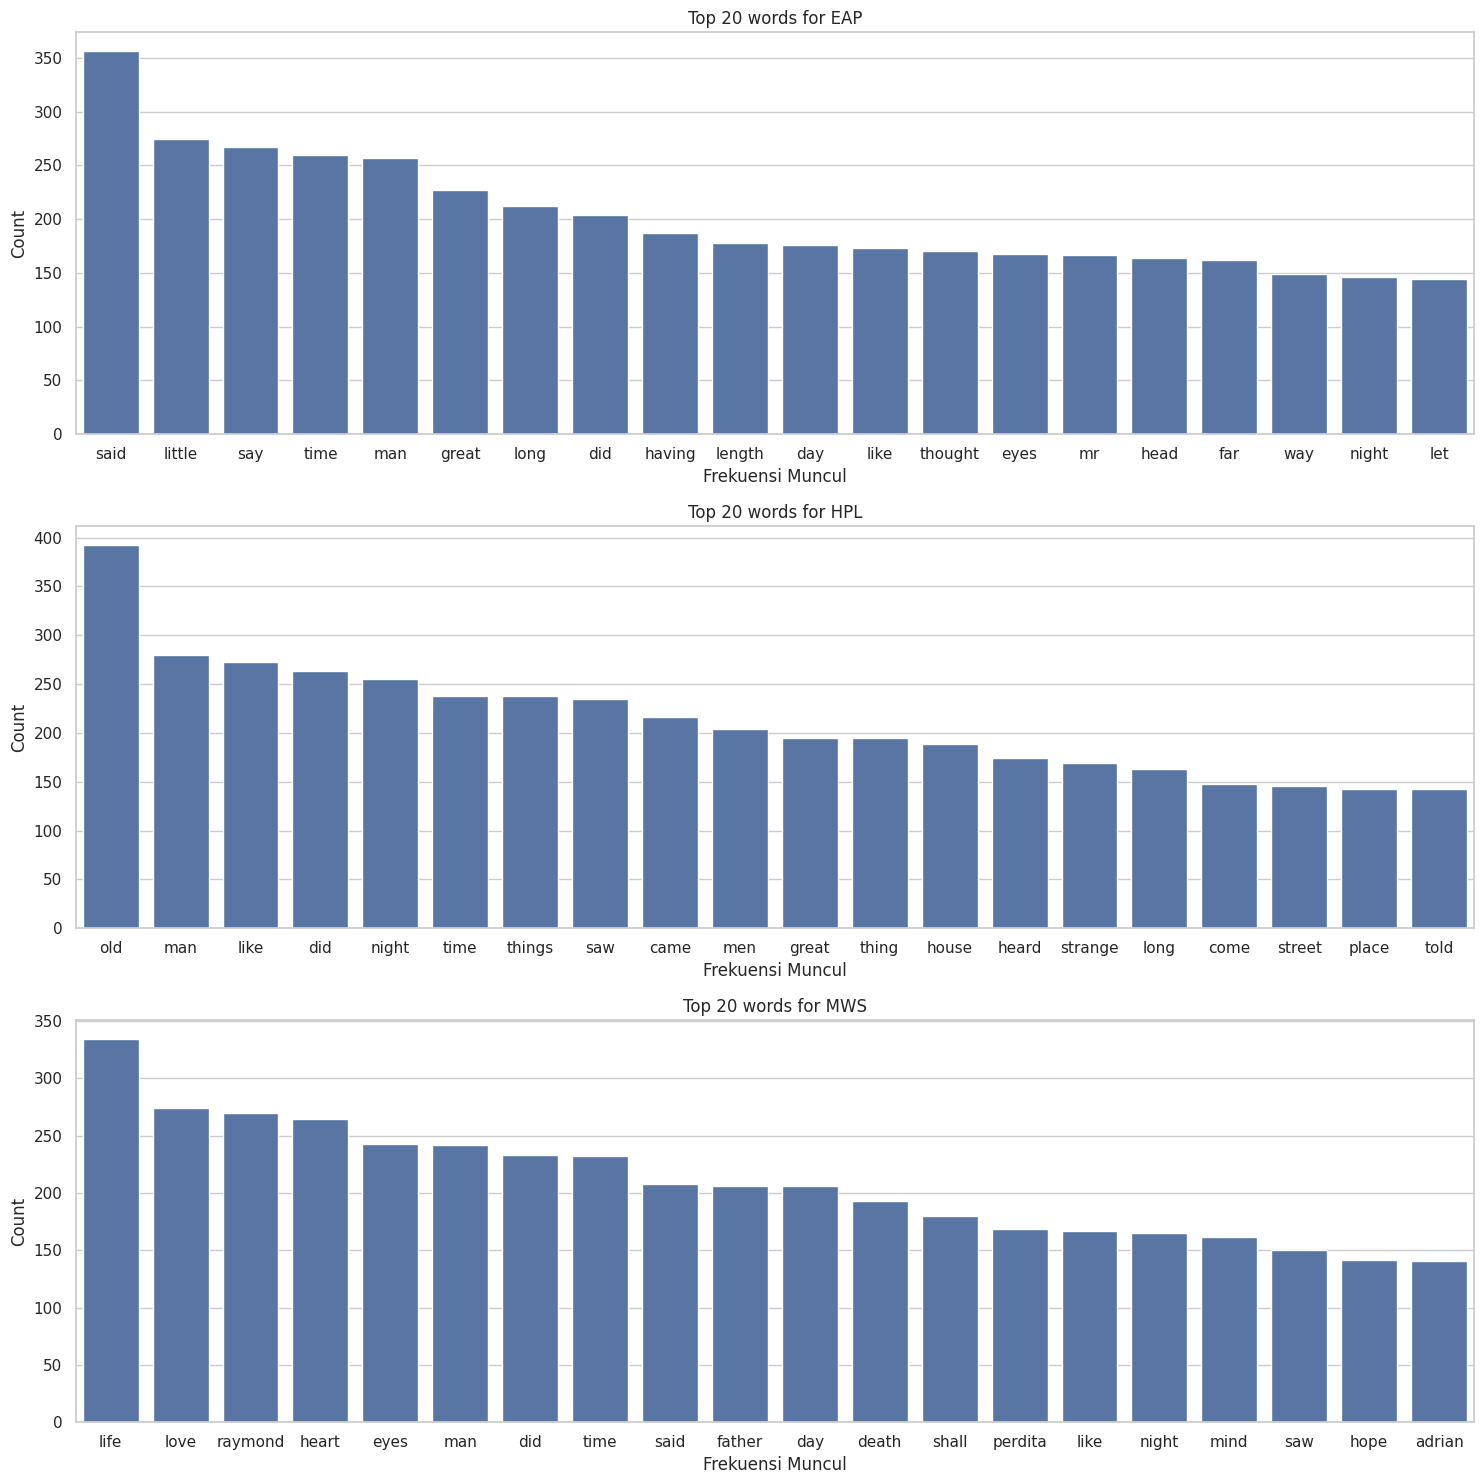

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def fet_top_words(corpus, n=None):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq=[(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
  return words_freq[:n]

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
authors = ['EAP', 'HPL', 'MWS']

for i, author in enumerate(authors):
  top_words = fet_top_words(train[train['author'] == author]['text'],20)
  df_words = pd.DataFrame(top_words, columns=['Word', 'Count'])

  sns.barplot(x='Word', y='Count', data=df_words, ax=axes[i])
  axes[i].set_title('Top 20 words for ' + author)
  axes[i].set_xlabel('Frekuensi Muncul')

plt.tight_layout()
plt.show()

**Classical Machine Learning Pipeline**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
text_col = 'text'
cols_meta=['num_word', 'num_chars', 'average_word_length', 'num_punc']

# branch 1: text -> tf-idf
text_transformer = TfidfVectorizer(
    ngram_range=(1, 3),
    min_df = 3,
    stop_words= None
)

#branch 2: number -> minmax scaller
meta_transformer = MinMaxScaler()

# Calculate meta features for test data (they were only calculated for train previously)
test['num_word'] = test['text'].apply(lambda x:len(str(x).split()))
test['num_chars'] = test['text'].apply(lambda x:len(str(x)))
test['average_word_length'] = test['num_chars']/test['num_word']
test['num_punc'] = test['text'].apply(lambda x:len([c for c in str(x) if c in string.punctuation]))

scaler = StandardScaler()
X_train_meta = scaler.fit_transform(train[cols_meta])
X_test_meta = scaler.transform(test[cols_meta])

preprocessor = ColumnTransformer(
    transformers=[
        ('text_h', text_transformer, text_col),
        ('meta_h', meta_transformer, cols_meta) # Changed meta_col to cols_meta
    ],
    remainder='drop'
)

In [ ]:
clf1 = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
clf2 = MultinomialNB(alpha = 0.01)
clf3 = SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-4, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', clf1), ('mnb', clf2), ('sgd', clf3)],
    voting='soft')

In [ ]:
model_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('clf', voting_clf)
])

In [ ]:
scores = cross_val_score(model_pipeline, train, train['author'], cv=3, scoring='neg_log_loss')
print(f"Log Loss: {-scores.mean():.4f}")

Log Loss: 0.4767


**Challenger: Deep Learning**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

#### Preprocessing

##### Tokenization

In [ ]:
maxWords = 20000
maxLen = 100
oovToken = "<OOV>"

tokenizer = Tokenizer(num_words=maxWords, oov_token=oovToken)
tokenizer.fit_on_texts(train['text'])

X_train_seq = tokenizer.texts_to_sequences(train['text'])
X_test_seq = tokenizer.texts_to_sequences(test['text'])

print(f"vocab size: {len(tokenizer.word_index)}")

vocab size: 25944


##### Padding

In [ ]:
X_train_pad = pad_sequences(X_train_seq, maxlen=maxLen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxLen, padding='post', truncating='post')

print(f"Ukuran data train final: {X_train_pad.shape}")

Ukuran data train final: (19579, 100)


##### Label encoding

In [ ]:
le = LabelEncoder()
y_train_int = le.fit_transform(train['author'])
print ("Mapping label:", dict(zip(le.classes_, le.transform(le.classes_))))

Mapping label: {'EAP': np.int64(0), 'HPL': np.int64(1), 'MWS': np.int64(2)}


In [ ]:
y_train_category = to_categorical(y_train_int)
print("Ukuran data y train:", {y_train_category.shape})

Ukuran data y train: {(19579, 3)}


##### Split Data

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_pad, y_train_category, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Embedding(input_dim=maxWords, output_dim=100, input_length=maxLen),
    SpatialDropout1D(0.2),
    GlobalAveragePooling1D(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

In [ ]:
print("Start training")

history = model.fit(
    X_tr, y_tr,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Start training
Epoch 1/30
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4135 - loss: 1.0769
Epoch 1: val_loss improved from inf to 0.91908, saving model to best_model.keras
490/490 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.4136 - loss: 1.0768 - val_accuracy: 0.5169 - val_loss: 0.9191 - learning_rate: 0.0010
Epoch 2/30
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6411 - loss: 0.8257
Epoch 2: val_loss improved from 0.91908 to 0.61191, saving model to best_model.keras
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6412 - loss: 0.8254 - val_accuracy: 0.7735 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 3/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7817 - loss: 0.5490
Epoch 3: val_loss improved from 0.61191 to 0.51001, saving model to best_model.keras
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7817 - loss: 0.5489 - val_accuracy: 0.7932 - val_loss: 0.5100 - learning_rate: 0.0010
Epoch 4/30
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 2

##### Evaluation

In [ ]:
best_model = tf.keras.models.load_model('best_model.keras')

In [ ]:
pred_val_dl = best_model.predict(X_val)
loss_dl = log_loss(np.argmax(y_val, axis=1), pred_val_dl)

print(f"Log Loss DL: {loss_dl:.4f}")

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Log Loss DL: 0.4246


**Submission File**

In [ ]:
import pandas as pd

# Make predictions on the test set using the best model
# Ensure best_model is loaded by executing the cell 'EtWdvAvnr2k1' first.
pred_test_final = best_model.predict(X_test_pad)

submission = pd.DataFrame(pred_test_final, columns=['EAP', 'HPL', 'MWS'])
submission.insert(0, 'id', test['id'])

file_name="submission_final_0.41.csv"
submission.to_csv('submission.csv', index=False)

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# **Final Report: Spooky Author Identification**

## **Project Overview**
Purpose: Predicting the author of the synopsis of classical horror (Edgar Allan Poe, H.P.Lovecraft, Mary Shelley). **Evaluation Metric:** Multi-class Logarithmic Loss (Log Loss). The lower the score, the more accurate the model's prediction. **Best Result: Val Log Loss ~0.42** (defeat the Baseline 0.47)

## **Methodology and Experiment**
In this project, a comparison is made between the Classical Machine Learning Model and the Modern Deep Learning to determine best performance.

**1. Phase 1: Classical Machine Learning (Baseline)**
* Method: Using **Ensemble Voting Classifier** (Soft Voting) that combine strength of 3 different algorithm in one Pipeline:
  1. Logistic Regression: To capture the linear relationship between words.
  2. Multinomial Naive Bayes: Classical probability algorithm that is effective for text data (word frequency)
  3. SGD Classifier (Modified Hubner): Stochastic Gradient Descent optimization that is efficient for high-dimensional data.
* Technique: **Soft Voting** used for counting the average prediction probability from 3 baseline models. The purpose is to create *robust* output.
* Result: Log Loss **~0.47**
* Analysis: Eventhough using ensemble approach that very strong, this model still limited in Bag-of-Words (TF-IDF) approach. Model doesn't understand word order or the context of the sentence. Therefore, model is less accurate than Deep Learning, which understands semantics.


**2. Phase 2: Deep Learning "FastText" Architecture**
* Method: **Embedding Layer** combined with **Global Average Pooling**
* Result: Log Loss **~0.41**
* Analysis: This model successfully catches the overall "feel" or style of language (Stylometry). By counting the average of word vectors (word embeddings) in one sentence, model can distinguish "dark" nuance by Lovecraft and "Melancholic" by Poe that more accurate compared with just counting word.

## **The Winning Model Architecture**
Best model uses a deep learning approach that efficient and robust.

**1. Embedding Layer (100 Dim)**

Key component of deep learning that tranforms words into mathematical vector. This enabling model understand that the words "spooky" and "scary" have a similar meaning (close vector position)


**2. SpatialDropout1D(0.2)**

A vital regularization technique that completely removes 1 feature path.This prevent overfitting by force model to considering the global context, rather than focusing on a single keyword.

**3. GlocalAveragePooling1D**

Summarize all sentece information to an average vector (Bag of Embeddings). This technique is very fast dan effective for classifing short text.

**4. Dense Layers + ReLu**

The neural network “brain” that processes the summary results into non-linear patterns.

**5. Output (Softmax)**

Produce prediction probability for 3 class (EAP, HPL, MWS)


## **Key Insight**

**1. Stopwords is the key:** Unlike sentiment analysis, in author identification, *Stopwords* (conjunction like 'thus', 'whilst', 'upon') must not be discharged. These words are "fingerprint" author style (Stylometry).

**2. Less is more:** The complicated LSTM Architecture actually loses to simple Global Average Pooling. This proves that for medium-sized datasets (~19k data), simpler models often have better generalization (test performance).

**3. Importance of dropout:** The use of SpatialDropout1D is key to preventing overfitting also decreasing gap between *Train Accuracy* and *Validation Accuracy*.

## **Recommendations for Future Work**

**1. Ensembling:** Combine this model prediction result with XGBoost or Logistic Regression (Weighted Blending)  potentially decreasing Log Loss to 0.3x

**2. Pre-trained Embeddings:** Using GloVe or FastText (who have been trained on Wikipedia) to replace Embedding layer that trained from zero. This can help model understand uncommon words.

**3. Tranformer Models:** For